In [85]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
import seaborn as sb
import torch
import torch.nn as nn
import torch.optim as optim
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
import random
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.metrics import cohen_kappa_score
import lightgbm as lgb
from skopt import BayesSearchCV
from scipy.optimize import minimize
from bayes_opt import BayesianOptimization
from sklearn.base import clone
import warnings
warnings.filterwarnings("ignore")



In [86]:
# Fix random state for reproducibility
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.enabled = False

SEED = 42
set_random_seed(SEED)

# Data observation

## CSV Data

In [87]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)

In [88]:
df_train = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/train.csv")
df_test = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/test.csv")
df_data_dict = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv")

In [89]:
print(f"Features size (Test): {len(df_test.columns)}")
print(f"Features size (Train): {len(df_train.columns)}")
print('-' * 20)
print(f"{'Features':<100}{'Test':<10}{'Train':<10}")
for i in range(len(df_train.columns) - 1):
    test_column_status = "Yes" if (df_train.columns[i] in df_test.columns) else "---"
    train_column_status = "Yes"
    attribute = f"{df_train.columns[i]}"
    print(f"{attribute:<100}{test_column_status:<10}{train_column_status:<10}")

Features size (Test): 59
Features size (Train): 82
--------------------
Features                                                                                            Test      Train     
id                                                                                                  Yes       Yes       
Basic_Demos-Enroll_Season                                                                           Yes       Yes       
Basic_Demos-Age                                                                                     Yes       Yes       
Basic_Demos-Sex                                                                                     Yes       Yes       
CGAS-Season                                                                                         Yes       Yes       
CGAS-CGAS_Score                                                                                     Yes       Yes       
Physical-Season                                                                  

In [90]:
unlabeled = df_train['sii'].isna().sum()
print(f"Unlabeled Data / Total = {unlabeled} / {len(df_train['sii'])}")

Unlabeled Data / Total = 1224 / 3960


In [91]:
# label distribution
df_train['sii'].value_counts()

sii
0.0    1594
1.0     730
2.0     378
3.0      34
Name: count, dtype: int64

## Parquet Data

In [92]:
ts_df = pd.read_parquet('/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=01085eb3', engine='pyarrow')

In [93]:
ts_df.describe()

,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
count,370956.000000,370956.000000,370956.000000,370956.000000,370956.000000,370956.000000,370956.000000,370956.000000,370956.000000,3.709560e+05,370956.000000,370956.0,370956.000000
mean,185477.500000,-0.343396,-0.055826,-0.254433,0.032946,-17.589041,0.035210,17.800735,3849.649414,4.338433e+13,3.963284,4.0,49.910686
std,107085.917566,0.516126,0.424303,0.564593,0.083798,39.895645,0.183652,73.023468,171.100159,2.513356e+13,1.994539,0.0,6.204418
min,0.000000,-2.284304,-2.276082,-1.022549,0.000000,-89.877220,0.000000,0.000000,3098.166748,0.000000e+00,1.000000,4.0,39.000000
25%,92738.750000,-0.784639,-0.312203,-0.753955,0.001059,-49.667419,0.000000,2.500000,3740.833252,2.147500e+13,2.000000,4.0,45.000000
50%,185477.500000,-0.473294,-0.018973,-0.354672,0.008127,-21.538264,0.000000,6.677332,3827.833252,4.355500e+13,4.000000,4.0,50.000000
75%,278216.250000,0.068885,0.206397,0.113704,0.026206,6.416064,0.000000,17.742268,3982.000000,6.532000e+13,6.000000,4.0,55.000000
max,370955.000000,1.000692,1.011419,1.299293,4.097965,88.478432,1.000000,2650.500000,4184.000000,8.639500e+13,7.000000,4.0,61.000000


Text(0, 0.5, 'X')

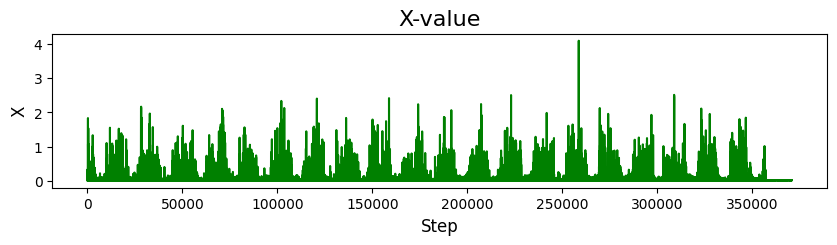

In [94]:
plt.figure(figsize=(10, 2)) 
plt.plot(ts_df['step'], ts_df['enmo'], color='g')
plt.title('X-value', fontsize=16)
plt.xlabel('Step', fontsize=12)
plt.ylabel('X', fontsize=12)

# Data Processing

In [95]:
is_aggregated = True
is_derived = True
is_removed_weak_correlation = False
weak_correlation_threshold = 0.07
dropped_columns = ['id', 'SDS-SDS_Total_T']

## CSV

In [96]:
df_train = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/train.csv")
df_test = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/test.csv")
df_data_dict = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv")

In [97]:
# Remove unlabeled data
# df_train = df_train.dropna(subset=['sii'])

# Drop columns > 60% Nan
# reliable_columns = df_train.columns[df_train.isna().mean() < 0.6]
# df_train = df_train[reliable_columns]

**Categorical Feature Encoding:** Categorical features are mapped to numeric values ​​using custom mappings for each unique category in the dataset.

In [98]:
season_cols = [
    'Basic_Demos-Enroll_Season',
    'CGAS-Season', 
    'Physical-Season',
    'Fitness_Endurance-Season',
    'FGC-Season',
    'BIA-Season',
    'PAQ_A-Season', 
    'PAQ_C-Season',
    'PCIAT-Season', 
    'SDS-Season',
    'PreInt_EduHx-Season',
]
# Create a mapping dictionary for seasons
season_mapping = {
    'Spring': 0,
    'Summer': 1,
    'Fall': 2,
    'Winter': 3
}

# Apply manual encoding to the categorical columns
def seasonMapping(dataframe):
    pd.set_option('future.no_silent_downcasting', True)
    for col in season_cols:
        if col in dataframe.columns:
            dataframe[col] = dataframe[col].replace(season_mapping)
            dataframe[col] = dataframe[col].astype(int)

def seasonRemoving(dataframe):
    season_cols = [col for col in dataframe.columns if 'Season' in col]
    dataframe = dataframe.drop(season_cols, axis=1)
    return dataframe

**Remove outliers:** Cleans the dataset by removing rows with abnormal or invalid values based on specific conditions defined for various features

In [99]:
def remove_outliers(df):
    
    df = df.drop(df[df['Physical-BMI'] == 0].index)
    df = df.drop(df[df['Physical-Diastolic_BP'] == 0].index)
    df = df.drop(df[df['Physical-Systolic_BP'] == 0].index)
    df = df.drop(df[df['Physical-Diastolic_BP'] > 160].index)

    children = df[df['Basic_Demos-Age'] <= 12]
    df = df.drop(children[children['FGC-FGC_CU'] > 80].index)
    df = df.drop(children[children['FGC-FGC_GSND'] > 80].index)

    df = df.drop(df[df['BIA-BIA_BMI'] == 0].index)
    df = df.drop(df[df['BIA-BIA_BMC'] > 1000].index)
    df = df.drop(df[df['BIA-BIA_BMR'] > 40000].index)
    df = df.drop(df[df['BIA-BIA_DEE'] > 60000].index)
    df = df.drop(df[df['BIA-BIA_ECW'] > 2000].index)
    df = df.drop(df[df['BIA-BIA_FFM'] > 2000].index)
    df = df.drop(df[df['BIA-BIA_ICW'] > 2000].index)
    df = df.drop(df[df['BIA-BIA_LDM'] > 2000].index)
    df = df.drop(df[df['BIA-BIA_LST'] > 2000].index)
    df = df.drop(df[df['BIA-BIA_SMM'] > 2000].index)
    df = df.drop(df[df['BIA-BIA_TBW'] > 2000].index)
    
    return df

**Derived attributes:** Calculate and add new columns based on existing columns in the DataFrame. Aim to create derived attributes (more meaningful features based on medical metrics and intuition), increase the variability of the data, and prepare for analysis and model training.

In [100]:
def derived_attributes(df):
    # season_cols = [col for col in df.columns if 'Season' in col]
    # df = df.drop(season_cols, axis=1) 
    df['Pulse_Pressure__'] = df['Physical-Systolic_BP'] - df['Physical-Diastolic_BP']
    df['Fat_Muscle_Ratio__'] = df['BIA-BIA_Fat'] / df['BIA-BIA_LDM']
    df['Weight_Height_Ratio__'] = df['Physical-Weight'] / df['Physical-Height']
    df['Physical_Sleep_Disturbance__'] = df['PAQ_C-PAQ_C_Total'] * df['SDS-SDS_Total_Raw']    
    
    #Age
    df['Internet_Hours_Age__'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Age__'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    df['Physical-Height_Age__'] = df['Basic_Demos-Age'] * df['Physical-Height']
    df['SDS_InternetHours__'] = df['SDS-SDS_Total_T'] * df['PreInt_EduHx-computerinternet_hoursday']

    #SDS
    df['SDS_Activity__'] = df['BIA-BIA_Activity_Level_num'] * df['SDS-SDS_Total_T']

    df['BMI_Systolic_BP__'] = df['BIA-BIA_BMI'] * df['Physical-Systolic_BP']
    df['Age_Systolic_BP__'] = df['Basic_Demos-Age'] * df['Physical-Systolic_BP']
    df['PreInt_Systolic_BP__'] = df['Physical-Systolic_BP'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['Activity_CU_PU__'] = df['BIA-BIA_Activity_Level_num'] * df['FGC-FGC_CU'] * df['FGC-FGC_PU']

    #FGC
    df['FGC_CU_PU__'] = df['FGC-FGC_CU'] * df['FGC-FGC_PU']
    df['FGC_CU_PU_Age__'] = df['FGC-FGC_CU'] * df['FGC-FGC_PU'] * df['Basic_Demos-Age']
    df['CGAS_CU_PU__'] = df['CGAS-CGAS_Score'] * df['FGC-FGC_CU'] * df['FGC-FGC_PU']
    df['PreInt_FGC_CU_PU__'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['FGC-FGC_CU'] * df['FGC-FGC_PU']

    return df

In [101]:
df_train = seasonRemoving(df_train)

In [102]:
# Get the common columns with test
common_columns = df_train.columns.intersection(df_test.columns)
df_train_no_label = df_train[common_columns].copy()
df_train_no_label['sii'] = df_train['sii']

df_train = df_train_no_label   # with label now
df_test = df_test[common_columns].copy()

In [103]:
# df_train = remove_outliers(df_train)
# df_test = remove_outliers(df_test)
#We are no longer using the remove outliers function because we found it to be inefficient.

In [104]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 50 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Age                         3960 non-null   int64  
 2   Basic_Demos-Sex                         3960 non-null   int64  
 3   CGAS-CGAS_Score                         2421 non-null   float64
 4   Physical-BMI                            3022 non-null   float64
 5   Physical-Height                         3027 non-null   float64
 6   Physical-Weight                         3076 non-null   float64
 7   Physical-Waist_Circumference            898 non-null    float64
 8   Physical-Diastolic_BP                   2954 non-null   float64
 9   Physical-HeartRate                      2967 non-null   float64
 10  Physical-Systolic_BP                    2954 non-null   floa

**Imputation of Missing Values:** Handle missing data in numeric columns of the train and test datasets using KNNImputer, ensuring data completeness for further analysis and model training.

In [105]:
# Use KNNImputer to handle missing data with k=7 nearest neighbors.
imputer = KNNImputer(n_neighbors=7)

# Extract numeric columns (int32, int64, float64) from train and test datasets.
numeric_cols_train = df_train.select_dtypes(include=['int32', 'int64', 'float64']).columns
numeric_cols_test = df_test.select_dtypes(include=['int32', 'int64', 'float64']).columns

# Apply KNNImputer to replace missing values in train and test datasets.
imputed_data_train = imputer.fit_transform(df_train[numeric_cols_train])
imputed_data_test = imputer.fit_transform(df_test[numeric_cols_test])

# Convert the imputed numpy arrays back into DataFrames and restore the 'id' column.
df_train_no_id = pd.DataFrame(imputed_data_train, columns=numeric_cols_train, index=df_train.index)
df_test_no_id = pd.DataFrame(imputed_data_test, columns=numeric_cols_test, index=df_test.index)


df_train_no_id['id'] = df_train['id']
df_test_no_id['id'] = df_test['id']

df_train = df_train_no_id
df_test = df_test_no_id


# Round the values in the 'sii' column in the train dataset and convert them to integers.
df_train['sii'] = df_train['sii'].round().astype(int)


In [106]:
if is_derived:
    derived_attributes(df_train)
    derived_attributes(df_test)

In [107]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 67 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Basic_Demos-Age                         3960 non-null   float64
 1   Basic_Demos-Sex                         3960 non-null   float64
 2   CGAS-CGAS_Score                         3960 non-null   float64
 3   Physical-BMI                            3960 non-null   float64
 4   Physical-Height                         3960 non-null   float64
 5   Physical-Weight                         3960 non-null   float64
 6   Physical-Waist_Circumference            3960 non-null   float64
 7   Physical-Diastolic_BP                   3960 non-null   float64
 8   Physical-HeartRate                      3960 non-null   float64
 9   Physical-Systolic_BP                    3960 non-null   float64
 10  Fitness_Endurance-Max_Stage             3960 non-null   floa

In [108]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 66 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Basic_Demos-Age                         20 non-null     float64
 1   Basic_Demos-Sex                         20 non-null     float64
 2   CGAS-CGAS_Score                         20 non-null     float64
 3   Physical-BMI                            20 non-null     float64
 4   Physical-Height                         20 non-null     float64
 5   Physical-Weight                         20 non-null     float64
 6   Physical-Waist_Circumference            20 non-null     float64
 7   Physical-Diastolic_BP                   20 non-null     float64
 8   Physical-HeartRate                      20 non-null     float64
 9   Physical-Systolic_BP                    20 non-null     float64
 10  Fitness_Endurance-Max_Stage             20 non-null     float64


## Parquet

In [109]:
train_parquet_dir = '/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/'
test_parquet_dir = '/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet/'

**Encoder-Decoder:** Utilize an encoder-decoder neural network to extract meaningful latent representations from time series data

In [110]:
class EncoderDecoderModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(EncoderDecoderModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, output_dim*3),
            nn.LeakyReLU(0.1),
            nn.Linear(output_dim*3, output_dim*2),
            nn.LeakyReLU(0.1),
            nn.Linear(output_dim*2, output_dim),
            nn.LeakyReLU(0.1),
        )

        self.decoder = nn.Sequential(
            nn.Linear(output_dim, output_dim*2),
            nn.LeakyReLU(0.1),
            nn.Linear(output_dim*2, output_dim*3),
            nn.LeakyReLU(0.1),
            nn.Linear(output_dim*3, input_dim),
            nn.LeakyReLU(0.1),
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))
        

In [111]:
def process_file(dirname, filename):
    '''
    arg;;
    return:
    '''
    # print(os.path.join(dirname, filename, 'part-0.parquet'))
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname):
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(dirname, fname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df

# This function trains an autoencoder or encoder-decoder neural network model using a specified training dataset
# and optionally evaluates it on a test dataset.

def encoderDecoderTrain(model, trainloader, testloader=None, epochs=50):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for batch in trainloader:
            batch = batch.to(device)
            optimizer.zero_grad()
            reconstructed = model(batch)
            loss = criterion(batch, reconstructed)
            total_train_loss += loss.item()
            loss.backward()
            optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch: {epoch}/{epochs}:')
            print(f"-->| Avg_train_loss: {total_train_loss / len(trainloader)}")
        
        if testloader:
            model.eval()
            total_test_loss = 0
            for batch in testloader:
                batch = batch.to(device)
                reconstructed = model(batch)
                loss = criterion(batch, reconstructed)
                total_test_loss += loss.item()
            if epoch % 10 == 0:
                print(f"-->| Avg_test_loss: {total_test_loss / len(testloader)}")
                

def perform_autoencoder(data_tensor, model):   
    model.eval()
    with torch.no_grad():
        encoded_data = model.encoder(data_tensor).numpy()
        
    df_encoded = pd.DataFrame(encoded_data, columns=[f'Enc_{i + 1}' for i in range(encoded_data.shape[1])])
    
    return df_encoded


In [112]:
ts_df_train = load_time_series(train_parquet_dir)
ts_df_test = load_time_series(test_parquet_dir)

100%|██████████| 2/2 [00:00<00:00, 10.32it/s]


In [113]:
ts_df_train_no_id = ts_df_train.drop(columns=['id'])
ts_df_test_no_id = ts_df_test.drop(columns=['id'])

In [114]:
scaler = StandardScaler()
ts_df_train_scaled = scaler.fit_transform(ts_df_train_no_id)
ts_df_test_scaled = scaler.transform(ts_df_test_no_id)

train_tensor = torch.FloatTensor(ts_df_train_scaled)
test_tensor = torch.FloatTensor(ts_df_test_scaled)

trainloader = DataLoader(train_tensor, shuffle=True, batch_size=32)
testloader = DataLoader(test_tensor, shuffle=True, batch_size=32)

In [115]:
model_train = EncoderDecoderModel(input_dim=train_tensor.shape[1], output_dim=70)
model_test = EncoderDecoderModel(input_dim=test_tensor.shape[1], output_dim=70)

In [116]:
encoderDecoderTrain(model_train, trainloader, None, epochs=150)
encoderDecoderTrain(model_test, testloader, None, epochs=150)

Epoch: 0/150:
-->| Avg_train_loss: 0.927288232371211
Epoch: 10/150:
-->| Avg_train_loss: 0.3326894626952708
Epoch: 20/150:
-->| Avg_train_loss: 0.22435159934684634
Epoch: 30/150:
-->| Avg_train_loss: 0.17572924168780446
Epoch: 40/150:
-->| Avg_train_loss: 0.14968318468891084
Epoch: 50/150:
-->| Avg_train_loss: 0.12713284161873162
Epoch: 60/150:
-->| Avg_train_loss: 0.1190591596532613
Epoch: 70/150:
-->| Avg_train_loss: 0.10579814785160124
Epoch: 80/150:
-->| Avg_train_loss: 0.09793273801915348
Epoch: 90/150:
-->| Avg_train_loss: 0.09119793330319226
Epoch: 100/150:
-->| Avg_train_loss: 0.09662209544330835
Epoch: 110/150:
-->| Avg_train_loss: 0.07755493198055774
Epoch: 120/150:
-->| Avg_train_loss: 0.07528706721495837
Epoch: 130/150:
-->| Avg_train_loss: 0.0703127512242645
Epoch: 140/150:
-->| Avg_train_loss: 0.061273197061382234
Epoch: 0/150:
-->| Avg_train_loss: 0.9531385898590088
Epoch: 10/150:
-->| Avg_train_loss: 0.7755685448646545
Epoch: 20/150:
-->| Avg_train_loss: 0.4713918864727

In [117]:
encoded_ts_df_train_no_id = perform_autoencoder(train_tensor, model_train)
encoded_ts_df_test_no_id = perform_autoencoder(test_tensor, model_test)

In [118]:
encoded_ts_df_train_no_id['id'] = ts_df_train['id']
encoded_ts_df_test_no_id['id'] = ts_df_test['id']

encoded_ts_df_train = encoded_ts_df_train_no_id
encoded_ts_df_test = encoded_ts_df_test_no_id

## On processing

**Merging csv data and time series data**

In [119]:
def aggregate_row(csv_df, encoded_ts_df):
    aggregated = csv_df.merge(encoded_ts_df, on='id', how='left').fillna(-1)
    return aggregated

In [120]:
if is_aggregated:
    aggregated_train = aggregate_row(df_train, encoded_ts_df_train)
    aggregated_test = aggregate_row(df_test, encoded_ts_df_test)
else:
    aggregated_train = df_train
    aggregated_test = df_test

In [121]:
df_aggregated_test = aggregated_test
df_aggregated_train = aggregated_train

In [122]:
# df_aggregated_train = df_aggregated_train.fillna(-1) # (Fill -1)
# seasonMapping(df_aggregated_train) # (Fill -1)
df_aggregated_train = df_aggregated_train.drop(columns=dropped_columns)

# df_aggregated_train = seasonRemoving(df_aggregated_train)
# df_aggregated_train = df_aggregated_train.drop(columns=dropped_columns)
# df_aggregated_train = df_aggregated_train.fillna(df_aggregated_train.mean())


In [123]:
# df_aggregated_test = df_aggregated_test.fillna(-1) # (Fill -1) 
# seasonMapping(df_aggregated_test) # (Fill -1)
df_aggregated_test = df_aggregated_test.drop(columns=dropped_columns)

# df_aggregated_test = seasonRemoving(df_aggregated_test)
# df_aggregated_test = df_aggregated_test.drop(columns=dropped_columns)
# df_aggregated_test = df_aggregated_test.fillna(df_aggregated_test.mean())


In [124]:
# Filter weak correlated features
pd.set_option('display.max_rows', None)
print(df_aggregated_train.corr()['sii'])

if is_removed_weak_correlation:
    strong_correlated_columns = df_aggregated_train.columns[np.abs(df_aggregated_train.corr()['sii']) > weak_correlation_threshold]
    df_aggregated_train = df_aggregated_train[strong_correlated_columns]
    
pd.set_option('display.max_rows', 10)



Basic_Demos-Age                           0.423054
Basic_Demos-Sex                          -0.087627
CGAS-CGAS_Score                           0.012944
Physical-BMI                              0.250542
Physical-Height                           0.433790
Physical-Weight                           0.380446
Physical-Waist_Circumference              0.354391
Physical-Diastolic_BP                     0.049466
Physical-HeartRate                       -0.083298
Physical-Systolic_BP                      0.153453
Fitness_Endurance-Max_Stage              -0.064523
Fitness_Endurance-Time_Mins              -0.067860
Fitness_Endurance-Time_Sec               -0.083301
FGC-FGC_CU                                0.288515
FGC-FGC_CU_Zone                          -0.033108
FGC-FGC_GSND                              0.296521
FGC-FGC_GSND_Zone                         0.045006
FGC-FGC_GSD                               0.302021
FGC-FGC_GSD_Zone                          0.094097
FGC-FGC_PU                     

In [125]:
# df_aggregated_train = df_train
# df_aggregated_train = df_aggregated_train.fillna(0) # comment
# df_aggregated_test = df_test

#-------
label = df_aggregated_train['sii']
label

0       2
1       0
2       0
3       1
4       1
       ..
3955    1
3956    0
3957    1
3958    0
3959    0
Name: sii, Length: 3960, dtype: int64

In [126]:
common_columns = df_aggregated_train.columns.intersection(df_aggregated_test.columns)
df_aggregated_train = df_aggregated_train[common_columns]
df_aggregated_test = df_aggregated_test[common_columns]

In [127]:
if len(df_aggregated_train.columns) <= 70:
    corr_matrix = df_aggregated_train.corr()
    plt.figure(figsize=(12, 8))  # Adjust the figure size (width, height)
    sb.heatmap(np.abs(corr_matrix), annot=True, fmt=".2f", cmap="coolwarm")
    plt.show()

In [128]:
pd.set_option('display.max_columns', None)
# df_aggregated_train = df_aggregated_train.copy()
# df_aggregated_train['sii'] = label
df_aggregated_train

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,PreInt_EduHx-computerinternet_hoursday,Pulse_Pressure__,Fat_Muscle_Ratio__,Weight_Height_Ratio__,Physical_Sleep_Disturbance__,Internet_Hours_Age__,BMI_Age__,Physical-Height_Age__,SDS_InternetHours__,SDS_Activity__,BMI_Systolic_BP__,Age_Systolic_BP__,PreInt_Systolic_BP__,Activity_CU_PU__,FGC_CU_PU__,FGC_CU_PU_Age__,CGAS_CU_PU__,PreInt_FGC_CU_PU__,Enc_1,Enc_2,Enc_3,Enc_4,Enc_5,Enc_6,Enc_7,Enc_8,Enc_9,Enc_10,Enc_11,Enc_12,Enc_13,Enc_14,Enc_15,Enc_16,Enc_17,Enc_18,Enc_19,Enc_20,Enc_21,Enc_22,Enc_23,Enc_24,Enc_25,Enc_26,Enc_27,Enc_28,Enc_29,Enc_30,Enc_31,Enc_32,Enc_33,Enc_34,Enc_35,Enc_36,Enc_37,Enc_38,Enc_39,Enc_40,Enc_41,Enc_42,Enc_43,Enc_44,Enc_45,Enc_46,Enc_47,Enc_48,Enc_49,Enc_50,Enc_51,Enc_52,Enc_53,Enc_54,Enc_55,Enc_56,Enc_57,Enc_58,Enc_59,Enc_60,Enc_61,Enc_62,Enc_63,Enc_64,Enc_65,Enc_66,Enc_67,Enc_68,Enc_69,Enc_70
0,5.0,0.0,51.000000,16.877316,46.000000,50.8,23.000000,60.571429,82.714286,104.285714,4.142857,5.285714,36.142857,0.000000,0.000000,15.042857,1.714286,13.885714,1.571429,0.000000,0.000000,7.000000,0.000000,6.000000,0.000000,6.000000,1.000000,2.000000,2.668550,16.879200,932.498000,1492.000000,8.255980,41.586200,13.817700,3.061430,9.213770,1.000000,24.434900,8.895360,38.917700,19.541300,32.690900,2.597143,2.354286,45.000000,3.000000,43.714286,1.035795,1.104348,105.942857,15.000000,84.386578,230.000000,177.857143,118.571429,1760.259429,521.428571,312.857143,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
1,9.0,0.0,67.142857,14.035590,48.000000,46.0,22.000000,75.000000,70.000000,122.000000,5.000000,7.285714,21.428571,3.000000,0.000000,15.942857,1.714286,15.371429,1.571429,5.000000,0.000000,11.000000,1.000000,11.000000,1.000000,3.000000,0.000000,2.000000,2.579490,14.037100,936.656000,1498.650000,6.019930,42.029100,12.825400,1.211720,3.970850,1.000000,21.035200,14.974000,39.449700,15.410700,27.055200,2.454143,2.340000,46.000000,0.000000,47.000000,0.265183,0.958333,107.640000,0.000000,126.320313,432.000000,0.000000,128.000000,1712.526200,1098.000000,0.000000,30.000000,15.000000,135.000000,1007.142857,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0000

In [129]:
df_aggregated_test

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,PreInt_EduHx-computerinternet_hoursday,Pulse_Pressure__,Fat_Muscle_Ratio__,Weight_Height_Ratio__,Physical_Sleep_Disturbance__,Internet_Hours_Age__,BMI_Age__,Physical-Height_Age__,SDS_InternetHours__,SDS_Activity__,BMI_Systolic_BP__,Age_Systolic_BP__,PreInt_Systolic_BP__,Activity_CU_PU__,FGC_CU_PU__,FGC_CU_PU_Age__,CGAS_CU_PU__,PreInt_FGC_CU_PU__,Enc_1,Enc_2,Enc_3,Enc_4,Enc_5,Enc_6,Enc_7,Enc_8,Enc_9,Enc_10,Enc_11,Enc_12,Enc_13,Enc_14,Enc_15,Enc_16,Enc_17,Enc_18,Enc_19,Enc_20,Enc_21,Enc_22,Enc_23,Enc_24,Enc_25,Enc_26,Enc_27,Enc_28,Enc_29,Enc_30,Enc_31,Enc_32,Enc_33,Enc_34,Enc_35,Enc_36,Enc_37,Enc_38,Enc_39,Enc_40,Enc_41,Enc_42,Enc_43,Enc_44,Enc_45,Enc_46,Enc_47,Enc_48,Enc_49,Enc_50,Enc_51,Enc_52,Enc_53,Enc_54,Enc_55,Enc_56,Enc_57,Enc_58,Enc_59,Enc_60,Enc_61,Enc_62,Enc_63,Enc_64,Enc_65,Enc_66,Enc_67,Enc_68,Enc_69,Enc_70
0,5.0,0.0,51.000000,16.877316,46.000000,50.800000,25.4,74.571429,79.714286,115.428571,5.0,7.0,34.0,0.000000,0.000000,16.16,1.6,16.74,1.6,0.000000,0.000000,7.000000,0.000000,6.000000,0.000000,6.000000,1.000000,2.000000,2.668550,16.879200,932.498000,1492.000000,8.255980,41.586200,13.817700,3.061430,9.213770,1.000000,24.434900,8.895360,38.917700,19.541300,32.690900,1.04,2.031571,37.714286,3.000000,40.857143,1.035795,1.104348,76.619265,15.000000,84.386578,230.000000,160.714286,107.142857,1948.341943,577.142857,346.285714,0.000000,0.000000,0.000000,0.000000,0.000000,-1.00000,-1.0000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.00000,-1.000000,-1.000000,-1.00000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
1,9.0,0.0,64.285714,14.035590,48.000000,46.000000,22.0,75.000000,70.000000,122.000000,5.0,7.0,34.0,3.000000,0.000000,16.16,1.6,16.74,1.6,5.000000,0.000000,11.000000,1.000000,11.000000,1.000000,3.000000,0.000000,2.000000,2.579490,14.037100,936.656000,1498.650000,6.019930,42.029100,12.825400,1.211720,3.970850,1.000000,21.035200,14.974000,39.449700,15.410700,27.055200,1.04,2.340000,46.000000,0.000000,47.000000,0.265183,0.958333,107.640000,0.000000,126.320313,432.000000,0.000000,128.000000,1712.526200,1098.000000,0.000000,30.000000,15.000000,135.000000,964.285714,0.000000,-1.00000,-1.0000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.00000,-1.000000,-1.000000,-1.00000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000

In [130]:
# df_aggregated_train.hist(figsize=(20, 20), bins=100, edgecolor='black')
# plt.tight_layout()
# plt.show()

**Noise removal:** Removes outliers in specific columns of a dataset by capping values above certain thresholds to predefined limits, ensuring cleaner and more consistent data for analysis.

In [131]:
def noise_removal(df):
    # FGC-FGC_CU
    CU_noise_mask = df['FGC-FGC_CU'] > 60
    df.loc[CU_noise_mask, 'FGC-FGC_CU'] = 25
    
    # FGC-FGC_PU
    PU_noise_mask = df['FGC-FGC_PU'] > 35
    df.loc[PU_noise_mask, 'FGC-FGC_PU'] = 25
    
    # Physical_sleep_disturbance
    sleep_disturb_mask = df['Physical_Sleep_Disturbance__'] > 250
    df.loc[sleep_disturb_mask, 'Physical_Sleep_Disturbance__'] = 200

In [132]:
# noise_removal(df_aggregated_train)
# noise_removal(df_aggregated_test)
# We dont use this function in this version

In [133]:
# df_aggregated_train.hist(figsize=(20, 20), bins=100, edgecolor='black')
# plt.tight_layout()
# plt.show()

# Model Training

In [134]:
X_train, X_test, y_train, y_test = train_test_split(df_aggregated_train, label, test_size=0.2, random_state=SEED, stratify=label)

In [135]:
y_test.value_counts()

sii
0    419
1    283
2     83
3      7
Name: count, dtype: int64

In [136]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3168, 134)
(792, 134)
(3168,)
(792,)


## LightGBM

**weighted_kappa_metric:** calculate QWK value. 

**convert_to_class:** Converts continuous predictions (y_pred) into discrete classes (0, 1, 2, 3). 

**threshold_rounder:** Turn the sii from PCIAT_Total to categorical. 

**neg_evaluate_pred:** Return negative QWK score. This function evaluate the prediction of the model by first turn integer prediction values to categorical values and then calculate QWK from it and the true labels.


In [137]:
def convert_to_class(y_pred, threshold=None):
    if threshold is None:
        y_pred_round = np.round(y_pred).astype(int)
        y_pred_clipped = np.clip(y_pred_round, 0, 3)
        return y_pred_clipped
    return threshold_rounder(y_pred, threshold)

def weighted_kappa_metric(y_true, y_pred):
    kappa_score = cohen_kappa_score(y_true, convert_to_class(y_pred=y_pred), weights="quadratic")
    return kappa_score

def threshold_rounder(y_pred, threshold):
    # threshold = [threshold_0_1, threshold_1_2, threshold_2_3]
    return np.where(y_pred < threshold[0], 0, 
                   np.where(y_pred < threshold[1], 1, 
                           np.where(y_pred < threshold[2], 2, 3)))

def neg_evaluate_pred(threshold, y_true, y_pred):
    y_pred = convert_to_class(y_pred, threshold)
    return -weighted_kappa_metric(y_true, y_pred)

**Bayesian Optimization:** This below function performs hyperparameter optimization using Bayesian Optimization to find the best parameters for a LightGBM model, including custom thresholds for converting predictions to classes. It uses Stratified K-Fold cross-validation for robust evaluation.

In [138]:
def bayesian_optimization_with_threshold(X_train, y_train):
    def objective(max_depth, num_leaves, learning_rate, n_estimators, min_child_samples, subsample, 
                  colsample_bytree, reg_alpha, reg_lambda, threshold_1, threshold_2, threshold_3):
        params = {
            'max_depth': int(max_depth),
            'num_leaves': int(num_leaves),
            'learning_rate': learning_rate,
            'n_estimators': int(n_estimators),
            'min_child_samples': int(min_child_samples),
            'subsample': subsample,
            'colsample_bytree': colsample_bytree,
            'reg_alpha': reg_alpha,
            'reg_lambda': reg_lambda,
            'random_state': SEED,
        }
        thresholds = [threshold_1, threshold_2, threshold_3]

        SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
        oof_preds = np.zeros(len(y_train))
        
        for train_idx, val_idx in SKF.split(X_train, y_train):
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            
            model = LGBMRegressor(**params)
            model.fit(X_tr, y_tr)

            y_pred = model.predict(X_val)            
            thresholdOptimizer = minimize(
                neg_evaluate_pred,
                x0=thresholds,
                args=(y_val, y_pred),
                method="Nelder-Mead"
            )
            best_thresholds = thresholdOptimizer.x
            y_pred = convert_to_class(y_pred, best_thresholds)
            oof_preds[val_idx] = y_pred
        
        return -neg_evaluate_pred(None, y_train, oof_preds)

    params = {
        'max_depth': (3, 15),  # Range of max_depth
        'num_leaves': (7, 255),  # Range of num_leaves
        'learning_rate': (0.01, 0.2),  # Log-uniform distribution for learning rates
        'n_estimators': (50, 500),  # Number of trees
        'min_child_samples': (10, 50),
        'subsample': (0.5, 1.0),  # Subsample ratio to choose samples for training
        'colsample_bytree': (0.5, 1.0),  # Feature fraction to randomly choose feature for training
        'reg_alpha': (0.0, 10.0),  # L1 regularization
        'reg_lambda': (0.0, 10.0),  # L2 regularization
        'threshold_1': (0.0, 1.0),
        'threshold_2': (1.0, 2.0),
        'threshold_3': (2.0, 3.0)
    }
    
    optimizer = BayesianOptimization(
        f=objective,
        pbounds=params,
        random_state=SEED,
    )

    optimizer.maximize(init_points=5, n_iter=30)
    return optimizer.max['params']

In [139]:
# X_train = df_aggregated_train
# y_train = label

best_params = bayesian_optimization_with_threshold(X_train, y_train)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample | thresh... | thresh... | thresh... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27895
[LightGBM] [Info] Number of data points in the train set: 2534, number of used features: 134
[LightGBM] [Info] Start training from score 0.594712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

In [140]:
best_params

{'colsample_bytree': 0.5896877535750842,
 'learning_rate': 0.03514239607098325,
 'max_depth': 10.238724166299402,
 'min_child_samples': 25.662201783702603,
 'n_estimators': 102.80505566036278,
 'num_leaves': 126.46139009022144,
 'reg_alpha': 2.3436288471689104,
 'reg_lambda': 3.7301995978770552,
 'subsample': 0.686744943865816,
 'threshold_1': 0.5319702986651922,
 'threshold_2': 1.1335105597952635,
 'threshold_3': 2.731396910349238}

In [141]:
best_params['max_depth'] = int(best_params['max_depth'])
best_params['num_leaves'] = int(best_params['num_leaves'])
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['min_child_samples'] = int(best_params['min_child_samples'])


In [142]:
best_params

{'colsample_bytree': 0.5896877535750842,
 'learning_rate': 0.03514239607098325,
 'max_depth': 10,
 'min_child_samples': 25,
 'n_estimators': 102,
 'num_leaves': 126,
 'reg_alpha': 2.3436288471689104,
 'reg_lambda': 3.7301995978770552,
 'subsample': 0.686744943865816,
 'threshold_1': 0.5319702986651922,
 'threshold_2': 1.1335105597952635,
 'threshold_3': 2.731396910349238}

In [143]:
LGBM_model = LGBMRegressor(**best_params, random_state=SEED)
thresholds = [best_params['threshold_1'], best_params['threshold_2'], best_params['threshold_3']]

In [144]:
LGBM_model.fit(X_train, y_train)

y_pred = LGBM_model.predict(X_test)
thresholdOptimizer = minimize(
    neg_evaluate_pred,
    x0=thresholds,
    args=(y_test, y_pred),
    method="Nelder-Mead"
)

best_thresholds = thresholdOptimizer.x

print(f"Weighted Kappa score: {-neg_evaluate_pred(best_thresholds, y_test, y_pred)}")

[LightGBM] [Warning] Unknown parameter: threshold_2
[LightGBM] [Warning] Unknown parameter: threshold_1
[LightGBM] [Warning] Unknown parameter: threshold_3
[LightGBM] [Warning] Unknown parameter: threshold_2
[LightGBM] [Warning] Unknown parameter: threshold_1
[LightGBM] [Warning] Unknown parameter: threshold_3
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29478
[LightGBM] [Info] Number of data points in the train set: 3168, number of used features: 134
[LightGBM] [Info] Start training from score 0.594381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

**Importance graph**: Here, we plot the importance of features that model thinks. Obviously, some derived attributes make positive effect to model awareness

<BarContainer object of 134 artists>

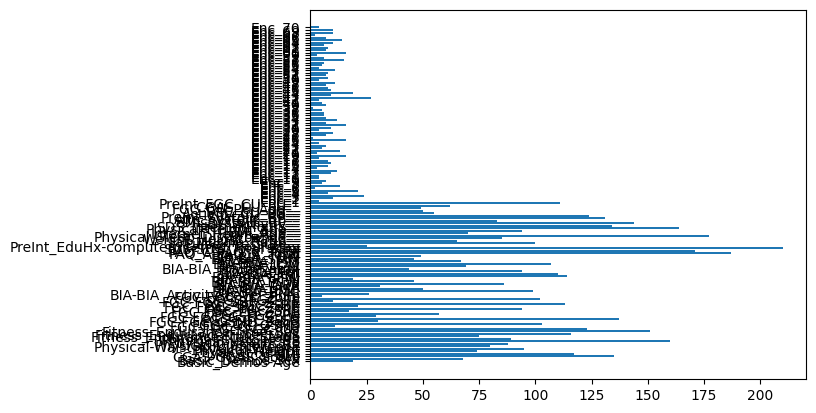

In [145]:
lgbm_importance = LGBM_model.feature_importances_

plt.barh(X_train.columns, lgbm_importance)


# Model Evaluation

In [146]:
# Random Forest
# y_pred = rf_model.predict(X_test)

# XGBoost
# y_pred = XGBoost_model.predict(X_test)

# LightGBM
y_pred = LGBM_model.predict(X_test)
y_pred_train = LGBM_model.predict(X_train)

# CatBoost

# y_pred = CatBoost_model.predict(X_test)

# Model Ensemble
# y_pred = ensemble_model.predict(X_test)

[LightGBM] [Warning] Unknown parameter: threshold_2
[LightGBM] [Warning] Unknown parameter: threshold_1
[LightGBM] [Warning] Unknown parameter: threshold_3
[LightGBM] [Warning] Unknown parameter: threshold_2
[LightGBM] [Warning] Unknown parameter: threshold_1
[LightGBM] [Warning] Unknown parameter: threshold_3


In [147]:
print(classification_report(convert_to_class(y_pred, best_thresholds), y_test))
print(classification_report(convert_to_class(y_pred_train, best_thresholds), y_train))

print(confusion_matrix(convert_to_class(y_pred, best_thresholds), y_test))

print(f"Weighted Kappa score on test: {-neg_evaluate_pred(best_thresholds, y_test, y_pred)}")
print(f"Weighted Kappa score on train: {-neg_evaluate_pred(best_thresholds, y_train, y_pred_train)}")

# y_pred

              precision    recall  f1-score   support

           0       0.76      0.80      0.78       394
           1       0.64      0.56      0.60       319
           2       0.29      0.30      0.30        79
           3       0.00      0.00      0.00         0

    accuracy                           0.66       792
   macro avg       0.42      0.42      0.42       792
weighted avg       0.66      0.66      0.66       792

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1638
           1       0.76      0.77      0.77      1124
           2       0.73      0.60      0.66       406
           3       0.00      0.00      0.00         0

    accuracy                           0.82      3168
   macro avg       0.60      0.57      0.58      3168
weighted avg       0.83      0.82      0.82      3168

[[317  62  15   0]
 [ 94 180  44   1]
 [  8  41  24   6]
 [  0   0   0   0]]
Weighted Kappa score on test: 0.5407461505690463
Weig

# Submit

In [148]:
y_pred = convert_to_class(LGBM_model.predict(df_aggregated_test), best_thresholds)

[LightGBM] [Warning] Unknown parameter: threshold_2
[LightGBM] [Warning] Unknown parameter: threshold_1
[LightGBM] [Warning] Unknown parameter: threshold_3


In [149]:
df_test = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/test.csv")
submission = pd.DataFrame({
    'id': df_test['id'],  # Include 'id' from test_data
    'sii': y_pred  # Predictions from the model
})
print(submission.head())

         id  sii
0  00008ff9    0
1  000fd460    0
2  00105258    1
3  00115b9f    0
4  0016bb22    1


In [150]:
df = submission.to_csv('submission.csv', index=False)

In [151]:
submission['sii'].value_counts()

sii
1    13
0     7
Name: count, dtype: int64